In [1]:
import Generate_data as gen

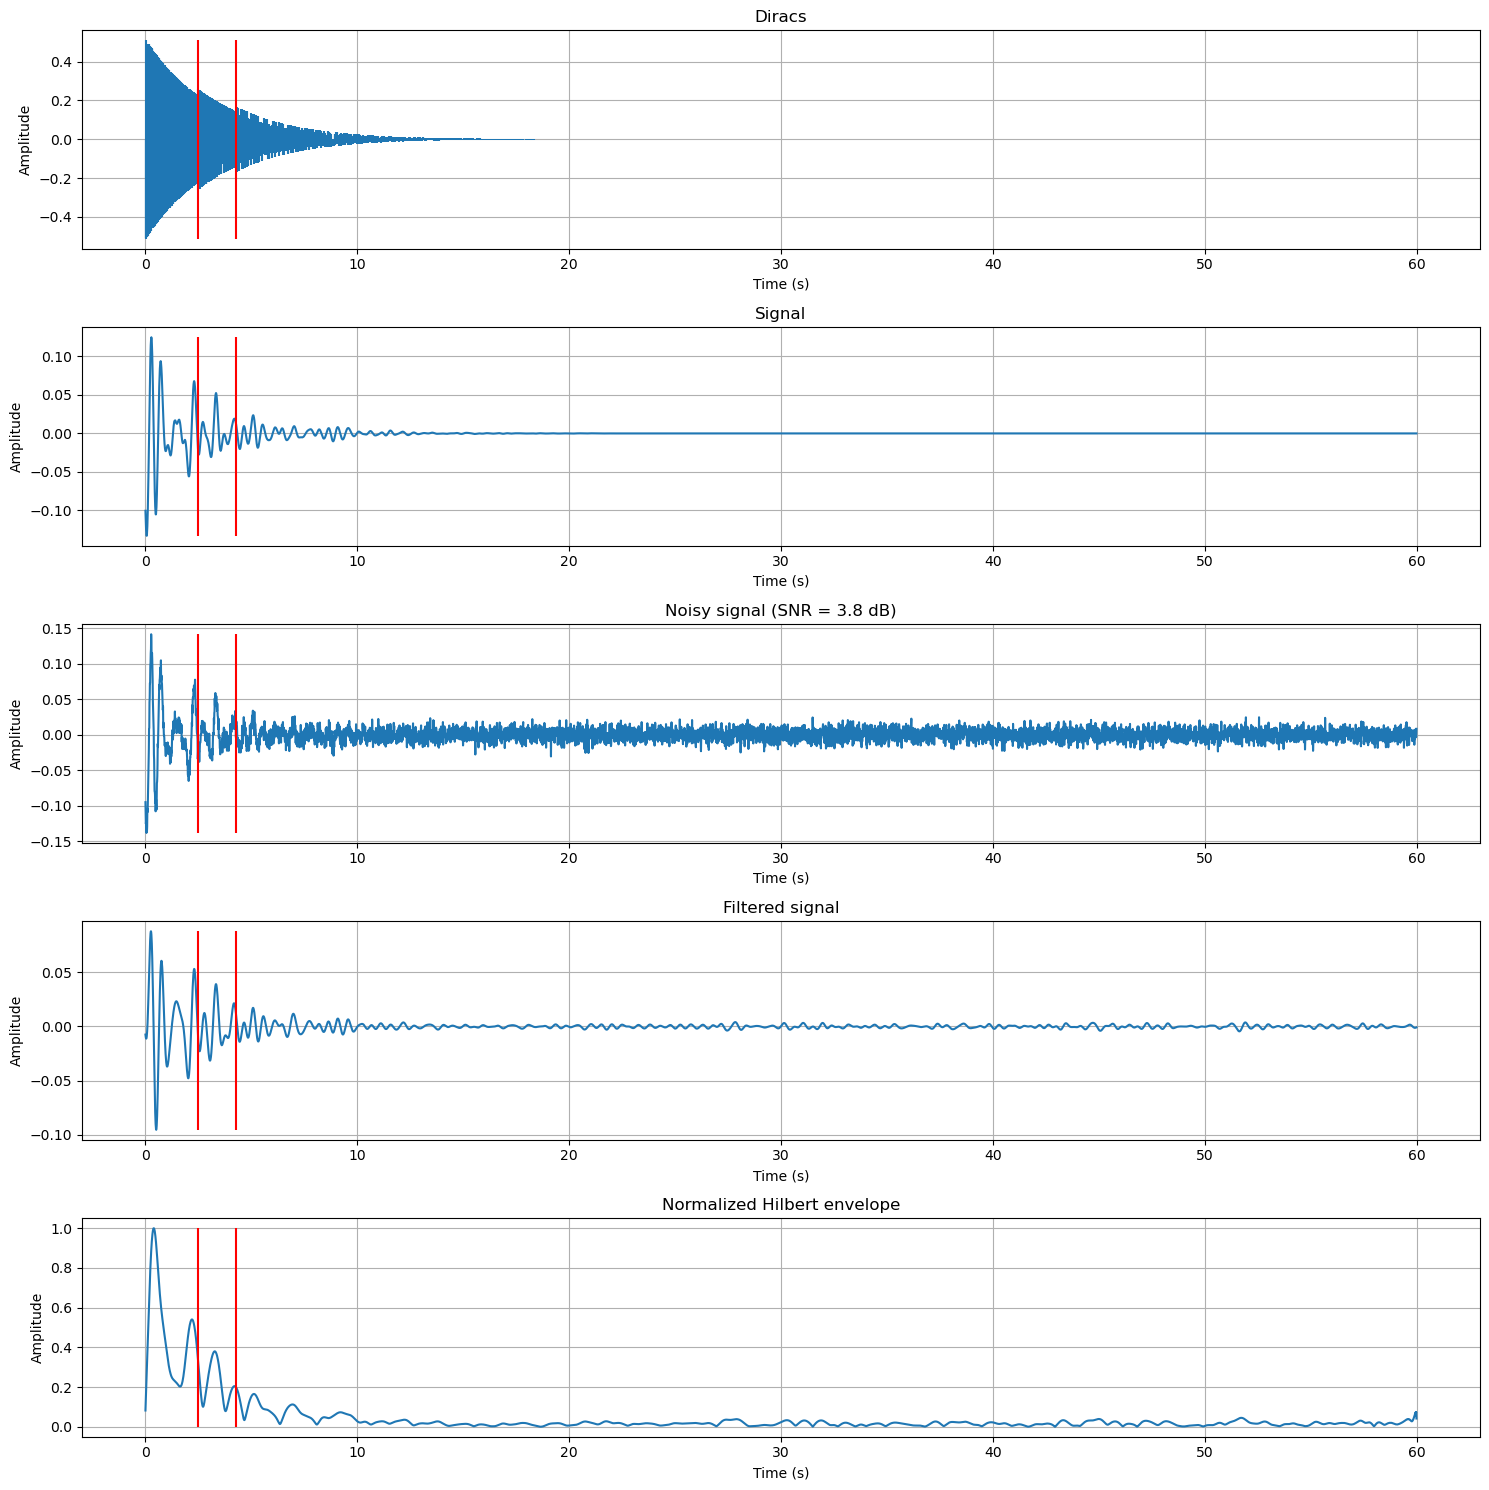

In [4]:
signal, source, station = gen.signal.generate_one_signal(plot=True)

## Model CNN

In [ ]:
# Initiate model
X_tensor, y_tensor, dataset, dataloader, model, criterion, optimizer = gen.model.initiate_model()

In [ ]:
# Train model
gen.model.train_model(model, dataloader, criterion, optimizer, epochs=20)

In [ ]:
# Test model
gen.model.test_model(model)